# Classifying Waveform to Cell Type  

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from sklearn.model_selection import train_test_split
import random

In [2]:
### data setup

path = os.getcwd() # put this file in the same dir as the root dir of the training data
data_root = os.path.join(path,'tactile-coding')
subj_paths = [d for d in os.listdir(data_root) if int(d) <= 12] # only first 12 subjs have EEG data

dataset = []
for subj in subj_paths:
    subj_path = os.path.join(data_root,subj,'tables')
    
    # already sorted based on source id --> rows correspond in each
    waveforms = pd.read_csv(os.path.join(subj_path,'waveforms.csv'))
    units = pd.read_csv(os.path.join(subj_path,'units.csv'))
    cell_types = units['cellType']
    
    # alignment
    waveforms['sourceId'] = units['sourceId']
    waveforms.set_index('sourceId',inplace = True)
    waveforms.columns = waveforms.columns.astype('float')
    
    data = pd.concat([waveforms,cell_types],axis=1)
    dataset += [data]

dataset = pd.concat(dataset)    

In [3]:
### summary stats (before feature scaling)
dataset.describe()

,-0.456,-0.432,-0.408,-0.384,-0.360,-0.336,-0.312,-0.288,-0.264,-0.240,...,0.576,0.600,0.624,0.648,0.672,0.696,0.720,0.744,0.768,0.792
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,...,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,10.029659,8.769840,7.805009,7.920143,9.124554,10.483341,10.740542,9.322774,6.915238,5.221296,...,18.154337,19.205510,19.423892,18.998948,18.464114,18.294765,18.558847,18.916584,18.901564,18.277156
std,7.164416,6.956953,7.115176,7.572240,8.049799,8.337685,8.185313,7.503434,6.866604,7.150363,...,12.277538,12.439587,12.271126,11.889122,11.578217,11.525188,11.660113,11.776651,11.688350,11.350874
min,-9.890981,-11.278459,-12.793783,-14.224825,-15.342163,-16.079247,-16.634413,-17.411121,-18.735771,-20.589755,...,-3.436565,-0.515685,0.901928,0.297399,-1.880569,-3.732465,-3.732060,-1.940554,0.314340,0.626751
25%,5.643221,4.367529,3.743892,3.620226,4.834043,5.345053,5.840404,4.708419,2.809788,1.121797,...,9.636551,10.295801,10.419676,10.456938,10.233866,10.013767,10.191324,10.487156,10.518900,10.097550
50%,8.298256,7.284326,6.431137,6.636220,7.651356,9.038336,9.138402,7.749955,5.701304,4.378724,...,16.594646,17.450666,17.902110,17.838124,17.325793,17.519072,17.665639,17.926998,17.767920,16.820155
75%,12.840808,11.761115,10.614292,10.751404,12.082574,13.558721,13.708897,12.236809,9.527960,8.380691,...,22.935223,24.632616,24.890273,25.681130,25.182700,24.982036,25.435171,25.974895,25.430603,24.213926
max,51.237390,49.385873,50.420746,55.145249,58.918286,60.539792,57.710993,52.041033,48.026294,49.693422,...,96.355554,97.930040,95.034924,87.712003,79.230945,73.445183,71.734186,72.537718,72.485025,68.959097


In [4]:
dataset.cellType.describe()

count               302
unique                3
top       RegularSpiker
freq                247
Name: cellType, dtype: object

The input domain has a 53 features, which could benefit from dimensionality reduction. The summary for the cell type categorical labels indicates that regular spikers dominate in the set of recorded waveforms. 

In [5]:
### extraction and preprocessing

X_df = dataset.drop(['cellType'],axis=1)
G_df = dataset['cellType']
features = X_df.columns.values

# feature scaling to standard normal
def normalize(arr):
    return (arr - np.mean(arr,axis=1).reshape(-1,1)) / np.std(arr,axis=1).reshape(-1,1)

X = normalize(X_df.values)
G = G_df.values

y = np.zeros(len(G))
labels = np.unique(G)
for i, label in enumerate(labels):
    y[G==label] = i

y = y.astype(int)

numeric_df = X_df.assign(y=y)

In [6]:
### plotting helpers

def meta(title,xlab,ylab,):
    sns.despine()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.yticks(range(-4,3,2))
    plt.ylim([-4.5, 3])
    plt.xticks(np.linspace(-0.4,.8,4))
    plt.xlim([-.5, .9])
    plt.title(title)

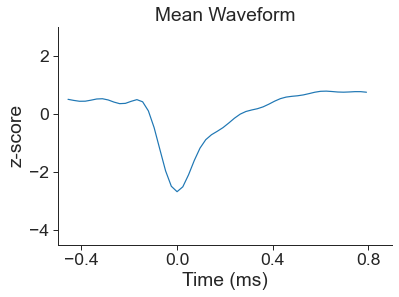

In [7]:
### visualize mean waveform

plt.plot(features,np.mean(X,axis=0))
meta('Mean Waveform','Time (ms)','z-score')

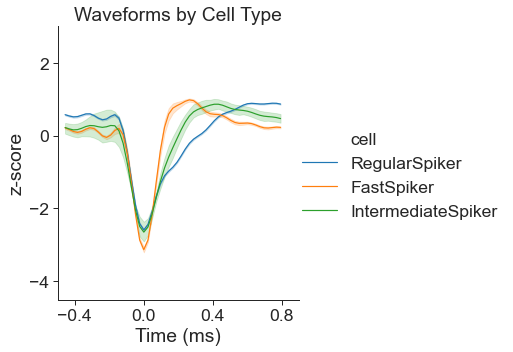

In [8]:
### visualize waveform cell types

# creating a long-form dataframe for seaborn plotting
points = []
r, c = X.shape
for i in range(r):
    for j in range(c):
        points += [(features[j],X[i,j],G[i])]

norm_data = pd.DataFrame(points,columns=['timepoint','signal','cell'])  

sns.relplot(data=norm_data,x='timepoint',y='signal',hue='cell',kind='line')
meta('Waveforms by Cell Type','Time (ms)','z-score')

Notice that the mean waveform is essentially the same waveform for regular spikers. Alongside the low variance of regular spikers, this info corroborates that regular spikers dominate this dataset. Upon inspection of the data, regular spikers are in fact the most common, followed by fast spikers, and lastly intermediate spikers which only comprise a handful of the measured neurons across all of the subjects. 

### KNN & K-Means Clustering   

Since regular spikers dominate this dataset, I expect that KNN alone won't be very accurate in the general case. 

In [9]:
class KNN:
    
    def __init__(self,X,y,labels,k):
        self.X = X
        self.y = y
        self.labels = labels
        self.k = k
        
    def euclidean_distance(self,X,x_0):
        """     
        vectorized Euclidean distance
        
        1. reshape y to row vector so that it broadcasts downward for subtraction on each row
        2. square each subtraction and sum across rows --> column vector
        3. square root of column vector --> distances
        """
        return np.sum((X-x_0.reshape(1,-1))**2,axis=1)**0.5
    
    def majority_vote(self,dists):
        """
        1. pair dists and associated class in a dataframe
        2. sort the dataframe by distance in ascending order
        3. select the top k nearest neighbors
        4. majority vote is the mode of the knns
        
        returns votes in a list
        
        edge cases: 
        equidistant to an equal number of points in multiple classes --> ambiguous vote
        """
        pdf = pd.DataFrame({'dists':dists,'y':self.y})
        pdf.sort_values(by=['dists'],inplace=True) # uses quicksort
        top_y = pdf.y[:self.k]
        mode = top_y.mode() # if len(mode) > 1, then there are ties
        
        ties = list(mode.values.astype(int))
        
        return random.choice(ties) # random choice of all ties
        
    
    def predict(self,x_0,dist='euclidean',vote='majority'):

        dists = None
        if dist == 'euclidean':
            dists = self.euclidean_distance(self.X,x_0)
        else:
            raise ValueError("Specified distance metric is undefined\n")
            
        cls = None
        if vote == 'majority':
            cls = self.majority_vote(dists)
        else:
            raise ValueError("Specified voting method is undefined\n")
        
        return cls
    
    def evaluate(self,Xt,yt):
        
        m = len(yt)
        correct = 0
        incorrect = []
        for i in range(m):
            cls = self.predict(Xt[i,:])
            if cls == yt[i]:
                correct += 1
            else:
                incorrect += [(i,cls,yt[i])]
            
        
        return correct / m, incorrect  
        

In [10]:
### choose best k

def choose_k(X,y,leeway=10):
    global labels
    
    X_b, X_v, y_b, y_v = train_test_split(X, y, test_size=0.1, random_state=123)
    max_k = len(X_b)
    
    k=1
    acc = 0
    cont = True
    best_k = k
    countdown = 0
    while cont and k <= max_k: 
        exp = KNN(X_b,y_b,labels,k)
        perf,_ = exp.evaluate(X_v,y_v)
        
        if perf <= acc: 
            cont = False if countdown > leeway else cont
            countdown += 1
        else:
            acc = perf
            best_k = k
            countdown = 0
        
        k += 1
    
    return best_k


In [11]:
### demonstrative testing

def test(X,y,seed):
    
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=seed)
    print("Seed =",seed)

    K = choose_k(X_tr,y_tr)
    print("Chosen k: ", K)

    knn = KNN(X_tr,y_tr,labels,K)
    test_perf, incorrect = knn.evaluate(X_te,y_te)
    print("Final accuracy: ",test_perf)
    print("Misclassified indices: ", incorrect)

    debug_perf, debug_incorrect = knn.evaluate(X_tr,y_tr)
    print("Debug accuracy: ", debug_perf)
    print("Misclassified indices: ", debug_incorrect)
    print()

test(X,y,123)
test(X,y,42)
test(X,y,66)

Seed = 123
Chosen k:  1
Final accuracy:  0.9032258064516129
Misclassified indices:  [(12, 0, 1), (13, 2, 1), (24, 1, 2)]
Debug accuracy:  1.0
Misclassified indices:  []

Seed = 42
Chosen k:  6
Final accuracy:  1.0
Misclassified indices:  []
Debug accuracy:  0.981549815498155
Misclassified indices:  [(41, 2, 1), (59, 0, 1), (104, 0, 1), (204, 2, 1), (260, 2, 1)]

Seed = 66
Chosen k:  1
Final accuracy:  1.0
Misclassified indices:  []
Debug accuracy:  1.0
Misclassified indices:  []



Forward selecting K, the model can achieve 100% accuracy (confirmed for seeds: 1, 42, 66; <100% for seeds: 123) on the test set depending on the data split and particularly the seed for the pseudo-rng. Although, if we evaluate the training set with the chosen k, then it sometimes doesn't achieve 100% training accuracy, which implies that the model is generalizable and apparently not overfitting the training data. Interestingly, the chosen K for this model oscillates between 1, 3, and 6. Does this foreshadow the best number for reduced dimensions for this data? 